In [1]:
import uol_redacoes_xml
essays = uol_redacoes_xml.load()

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup
import numpy as np
import requests
import re
import nltk
from nltk.corpus import wordnet as wn
from nltk.tokenize import sent_tokenize

nltk.download('punkt')
nltk.download('wordnet')

# Função para limpar e normalizar o texto
def clean_and_normalize_text(text):
    # Remover tags HTML
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # Converter para minúsculas
    text = text.lower()
    
    # Remover caracteres especiais, pontuações e números
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    return text

# Função para extrair o texto corrigido de uma redação como um vetor de contagem de palavras
def extract_corrected_text_vector(essay):
    corrected_text = ""
    soup = BeautifulSoup(essay.text, 'html.parser')
    spans = soup.find_all('span', class_='text-corrigido')
    for span in spans:
        # Verifica se a próxima tag é uma palavra corrigida
        next_tag = span.find_next_sibling()
        if next_tag and next_tag.name == 'span':
            corrected_word = next_tag.text.strip()
            corrected_text += corrected_word + " "
    return clean_and_normalize_text(corrected_text.strip())

# Função para calcular o número de palavras únicas em uma redação
def unique_words_count(essay):
    cleaned_text = clean_and_normalize_text(essay.text)
    return len(set(cleaned_text.split()))

# Função para calcular a repetição de palavras em relação ao vocabulário em uma redação
def word_repetition_ratio(essay):
    cleaned_text = clean_and_normalize_text(essay.text)
    words = cleaned_text.split()
    total_words = len(words)
    unique_words = len(set(words))
    return total_words / unique_words if unique_words != 0 else 0  # Evita divisão por zero
    
# Função para calcular o número de parágrafos em uma redação
def paragraph_count(essay):
    return essay.text.count('\n\n') + 1

# Função para calcular o tamanho médio dos parágrafos em uma redação
def average_paragraph_length(essay):
    cleaned_text = clean_and_normalize_text(essay.text)
    paragraphs = cleaned_text.split('\n\n')
    total_length = sum(len(paragraph.split()) for paragraph in paragraphs)
    return total_length / len(paragraphs) if len(paragraphs) != 0 else 0  # Evita divisão por zero

# Função para calcular o tamanho médio das palavras em uma redação
def average_word_length(essay):
    cleaned_text = clean_and_normalize_text(essay.text)
    words = cleaned_text.split()
    total_length = sum(len(word) for word in words)
    return total_length / len(words) if len(words) != 0 else 0  # Evita divisão por zero
    
# Função para verificar se o tema da redação está sendo abordado
def is_topic_covered(text, texts):
    cleaned_essay_text = clean_and_normalize_text(text)
    essay_words = set(cleaned_essay_text.lower().split())
    text_base_keywords = set(texts.split())
    return 1 if text_base_keywords.intersection(essay_words) else 0
    
def get_texts_base(essay):
    prompt_url = str(essay.prompt).split('\n')[1]

    # Realiza a requisição HTTP para obter o conteúdo da página
    response = requests.get(prompt_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    texts = []
    
    # Encontra a div com a classe 'text'
    text_div = soup.find('div', class_='text')
    if text_div is not None:
        texts.extend(clean_and_normalize_text(text_div.get_text().strip()).split())
        
        # Encontra todas as listas ul dentro da div
        ul_lists = text_div.find_all('ul', class_='article-wording-item')
        for ul_list in ul_lists[:-1]:  # Exclui o último item da lista
            for item in ul_list.find_all('li'):
                # text_base_articles.append(item.get_text().strip())
                texts.extend(clean_and_normalize_text(item.get_text().strip()).split())
        
        # Adiciona o texto base e os artigos a uma lista para usar no vetorizador
    return ' '.join(texts)

    
# Função para verificar palavras difíceis
def difficult_words_count(essay):
    difficult_words = set(wn.words())
    essay_words = set(clean_and_normalize_text(essay.text.lower()).split())
    return len(difficult_words.intersection(essay_words))

# Função para calcular complexidade sintática
def syntactic_complexity(essay):
    sentences = sent_tokenize(essay.text)
    avg_words_per_sentence = sum(len(sent.split()) for sent in sentences) / len(sentences)
    return avg_words_per_sentence

# Função para verificar conectores lógicos
def logical_connectives_count(essay):
    logical_connectives = [
    'portanto', 'assim', 'logo', 'então', 'por conseguinte', 'logo que', 
    'desta forma', 'dessa maneira', 'com isso', 'dessa forma', 'por isso', 'logo', 'então', 'por fim'
    'consequentemente', 'assim sendo', 'em suma', 'isto é', 'ou seja']
    essay_text = clean_and_normalize_text(essay.text.lower())
    count = sum(1 for connective in logical_connectives if connective in essay_text)
    return count

X = []
for essay in essays:
    text_base = get_texts_base(essay)
    X.append( [len(essay.text), len(essay.text.split()), unique_words_count(essay), word_repetition_ratio(essay),
      paragraph_count(essay), average_paragraph_length(essay), average_word_length(essay), 
      is_topic_covered(essay.text,text_base), difficult_words_count(essay), syntactic_complexity(essay), 
      logical_connectives_count(essay)])

y = [essay.final_score for essay in essays]


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alessandrabarros/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alessandrabarros/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn import model_selection
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from math import sqrt
import re
def eval_regression(gold_values, sys_values, model_name='', plot=False):
    '''
    Evaluate the semantic similarity output of the system against a gold score.
    Results are printed to stdout.
    Adapted from PROPOR-ASSIN Workshop.
    '''

    pearson = pearsonr(gold_values, sys_values)[0]
    absolute_diff = gold_values - sys_values
    rmse = sqrt((absolute_diff ** 2).mean())

    print('{:25}\t{:7}\t{:18}'.format('Modelo', 'Pearson', 'RMSE'))
    print('{:25}\t{:7.2f}\t{:18.2f}'.format(model_name, pearson, rmse))

    if plot:
        plt.figure(figsize=(8, 6))
        plt.title('Resultados')
        plt.scatter(gold_values, sys_values, alpha=.05, s=200)
        plt.plot([gold_values.min(), gold_values.max()], [gold_values.min(), gold_values.max()], 'k--', lw=4)
        plt.xlabel('Humano')
        plt.ylabel('Computador')
        plt.show()

    return pearson, rmse

def kfold_cross_validation(clf, X, y, n_sets=10, model_name='', plot=False):
    y_predicted = model_selection.cross_val_predict(clf, X, y, cv=n_sets)
    return eval_regression(y, y_predicted, model_name=model_name, plot=plot)

Modelo                   	Pearson	RMSE              
Baseline                 	   0.42	              2.06


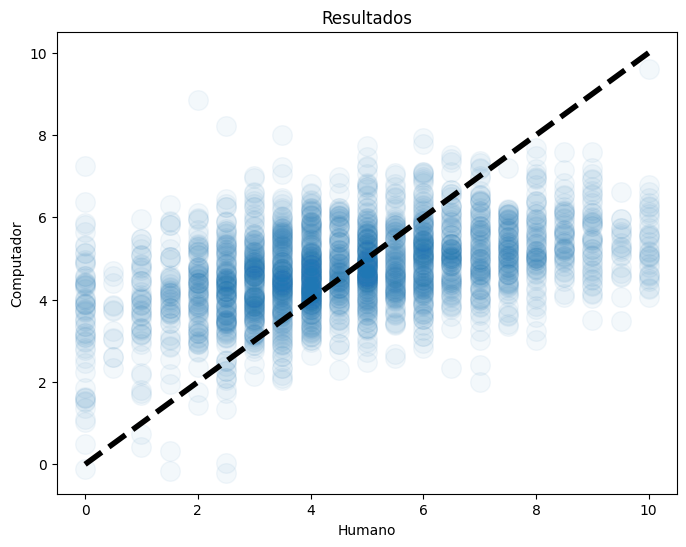

(0.42423503299313803, 2.0556837567254176)

In [20]:
import numpy as np

# Convertendo y em uma matriz NumPy bidimensional
y = np.array(y)

# Utilizando o modelo LinearRegression
from sklearn.linear_model import LinearRegression
model = LinearRegression()

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1, random_state=0)

regressor = LinearRegression(n_jobs=-1)
regressor.fit(X_train, y_train)

    
kfold_cross_validation(regressor, X, y, model_name='Baseline', plot=True)



In [ ]:
#valores com o teste original
(0.41524189720360904, 2.0634967855471933)